# <center>EWMA model for volatility prediction</center>

## Goal
Given the data of the record for daily volatility of the future rb. We want to predict the 5 days ahead volatility. 

## Assumption
The assumption is that volatility satisfies the normal distribution centered at 0. We will use the EWMA model to evaluate the next few days' volatility. We want find the parameter $\alpha$ for EWMA model to minimize the maximum likelihood estimators.

In [2]:
import pandas as pd
import numpy as np  
%matplotlib inline


df = pd.read_csv('1.csv')
df = df[['datetime','rb']]
df = df.dropna(axis=0, how='any')
df = df.reset_index(drop=True)
print(df.head())
df = df['rb'].values


  datetime        rb
0   4/3/09 -0.007198
1   4/7/09  0.012471
2   4/8/09 -0.008021
3   4/9/09  0.001444
4  4/10/09  0.004614


The variance is more stable with smaller alpha
Inivial value is set to be 1e-4, which is the mean of df**2

In [4]:
import numba
@numba.guvectorize([(numba.float64[:], numba.float64, numba.float64[:])],'(n),()->(n)', nopython=True)     
def variance(returns, alpha, results):
    tempo = 1e-4
    for i in range(len(returns)):
        tempo = (1-alpha)*tempo + alpha*returns[i]**2
        results[i] = tempo



To compute the log likelihood, we will throw away the first 100 points
step_ahead is the number of days ahead for forecasting



In [5]:
def log_like(step_ahead, alpha, returns):
    alpha = alpha[0]
    v = variance(returns, alpha)
    v = v[:-step_ahead]
    returns_shift = returns[step_ahead:]
    b = (- np.log(v) - (returns_shift ** 2)/ v)
    return sum(b[100:])/2

deriative of variance with respect to alpha

In [6]:
@numba.guvectorize([(numba.float64[:], numba.float64, numba.float64[:], numba.float64[:])],'(n),(),(n)->(n)',nopython=True)
def deri_v(returns, alpha, v, deri_v):
    tempo = 1e-4
    deri_v[0] = returns[0]**2 - tempo
    tempo = deri_v[0]
    for i in range(1, len(returns)):
        tempo = returns[i]**2 - v[i-1] + (1-alpha)*tempo
        deri_v[i] = tempo



deriative of log likelihood with respect to alpha

In [7]:
def deri_log(returns, step_ahead, alpha):
    alpha = alpha[0]
    v = variance(returns, alpha)
    deri = deri_v(returns, alpha, v)
    v = v[:-step_ahead]
    deri = deri[:-step_ahead]
    returns = returns[step_ahead:]
    a = (-1/v + (returns**2)/(v**2))*deri
    return sum(a[100:])/2;

To find the optimal alpha to maximize log likelihood
x_0 is the initial value to set
Bound for alpha is [1e-3, 0.2]

In [8]:
import scipy.optimize as optimize

def optimal_parameter(returns, step_ahead, x_0):
    fun = lambda alpha: -log_like(step_ahead, alpha, returns)
    deriative = lambda alpha: -deri_log(returns, step_ahead, alpha)
    bnds = [(1e-3,0.2)]
    res = optimize.minimize(fun, [x_0], method='SLSQP', bounds=bnds, jac=deriative)
    result = res.x[0]
    return result



Using expanding window to evaluate the model
Window length is the number of points needed to start the evaluation
x0 is the initial value to set
returns a list of alpha according to the varing expanding window

In [9]:
def expand_alpha(returns, step_ahead, window_length, x0):
    l = window_length
    initial = returns[:l+step_ahead]
    alpha = optimal_parameter(initial, step_ahead, x0)
    expand_alpha = []
    for j in range(0, l):
        expand_alpha.append(alpha)
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[: i+l+step_ahead]
        alpha = optimal_parameter(window, step_ahead, alpha)
        expand_alpha.append(alpha)
    return expand_alpha

Window length is the number of points needed to start the evaluation
x0 is the initial value to set
returns a list of variance computed by the above varing alpha



In [10]:
def expand_v(returns, step_ahead, window_length, x0):
    l = window_length
    initial = returns[:l+step_ahead]
    alpha = optimal_parameter(initial, step_ahead, x0)
    expand_v = variance(initial[:l], alpha)
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[: i+l+step_ahead]
        alpha = optimal_parameter(window, step_ahead, alpha)
        tempo = variance(returns[:i+l], alpha)[-1]
        expand_v = np.append(expand_v,tempo)
        
    return expand_v

Evaluation of the model
To compute the log likelihood, we throw away the window points and 100 points after the window

In [11]:
def expand_performance(returns, step_ahead, window_length, x0):
    estimate_v = expand_v(returns, step_ahead, window_length, x0)
    returns_shift =  returns[step_ahead:]
    b = (- np.log(estimate_v) - (returns_shift ** 2)/ estimate_v)
    return sum(b[100+window_length:]) / (2*(len(b)-window_length-100))



Take the first k points of df to draw the change of log likelihood 
by different alpha.

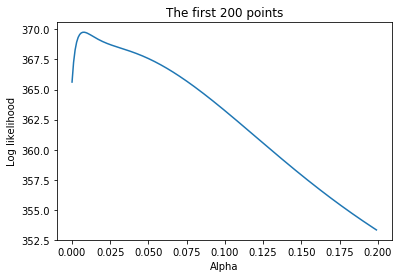

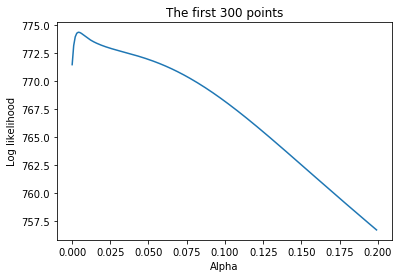

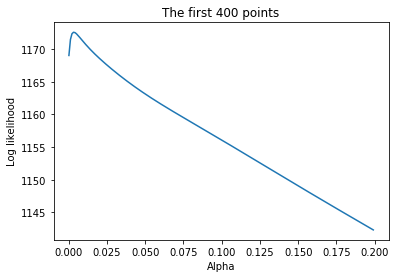

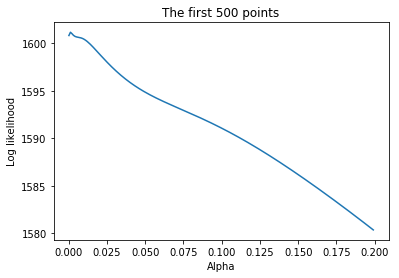

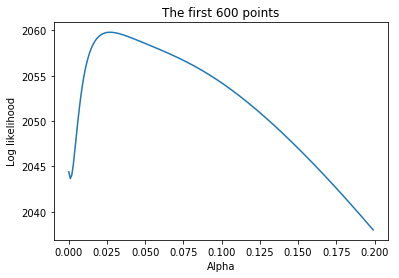

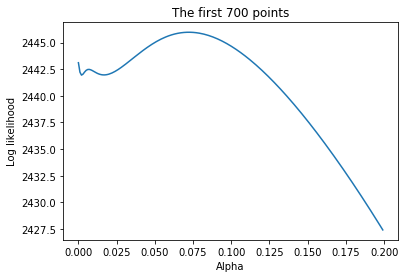

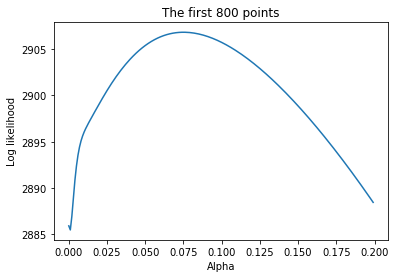

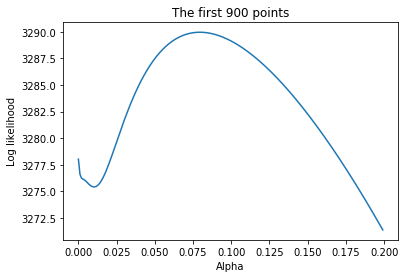

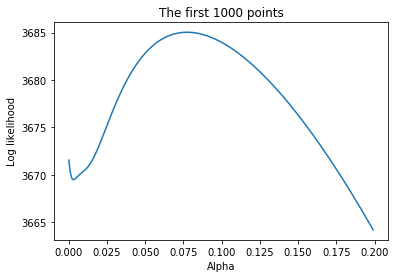

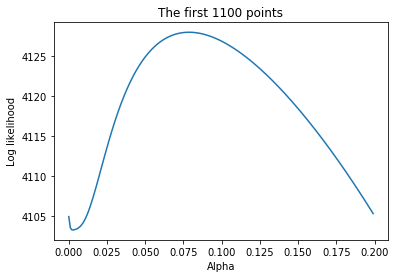

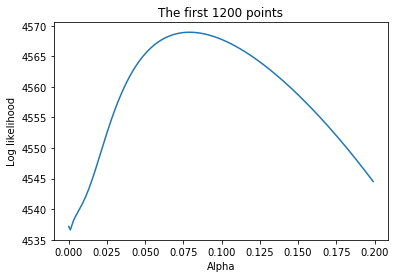

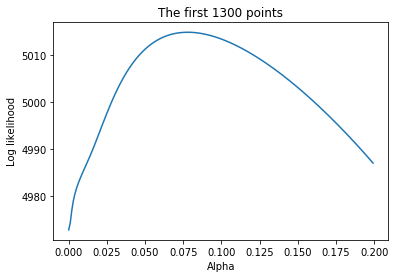

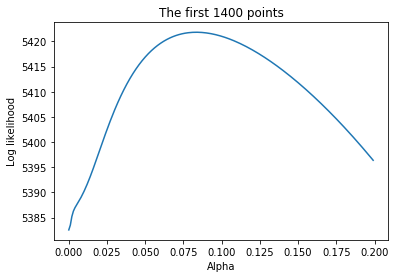

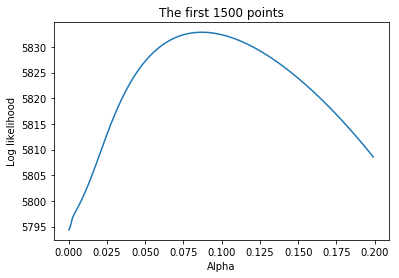

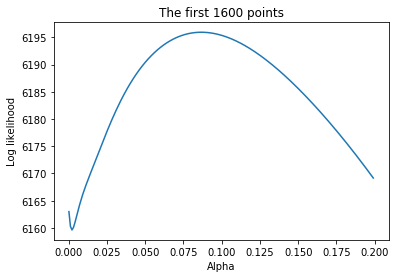

In [168]:
array = np.arange(0.0001,0.2,0.001)
for k in range(200, len(df), 100):
    a = [];
    for i in range(0, len(array)):
        a.append(log_like(5, [array[i]], df[:k]));
    plt.plot(array, a);
    plt.xlabel('Alpha')
    plt.ylabel('Log likelihood')
    plt.title('The first '+ str(k) +' points')
    plt.show()
    plt.close()

For example, set expanding window length=700, step_ahead=5,
the change of alpha is relatively stable with different initial values,
notice by the definition of expand alpha, the first 700 points has the same alpha.



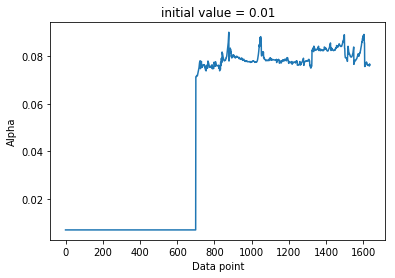

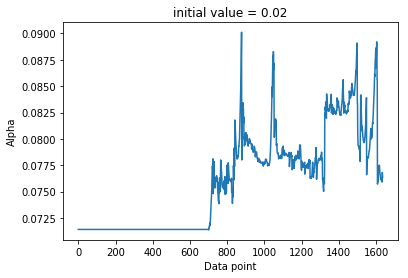

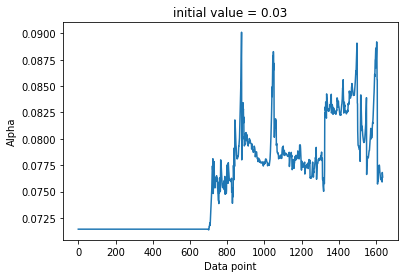

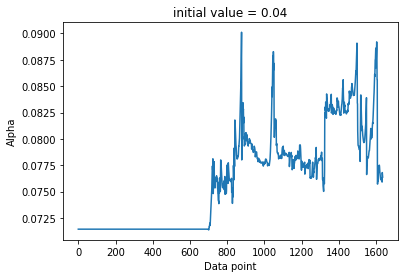

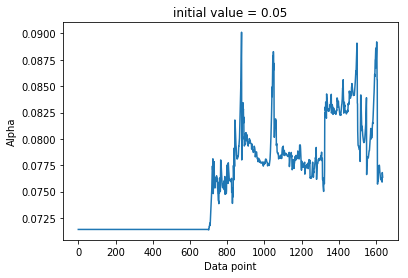

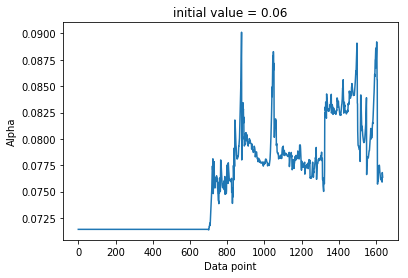

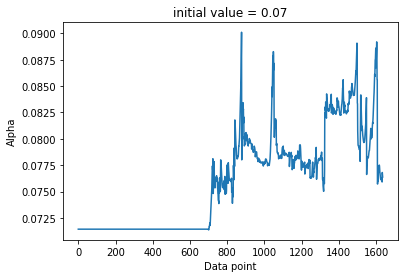

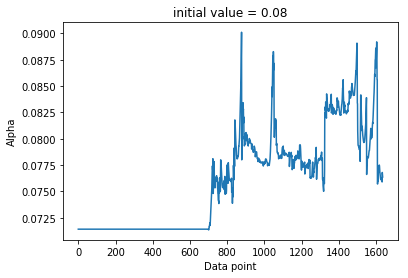

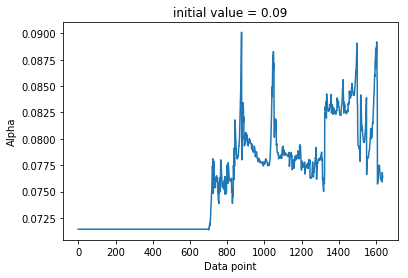

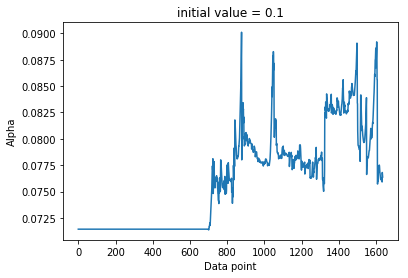

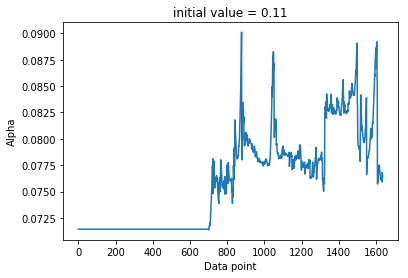

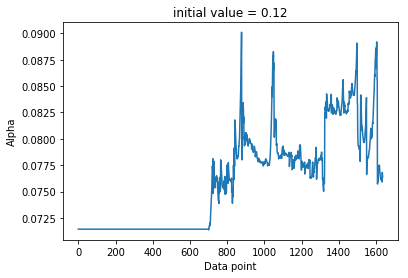

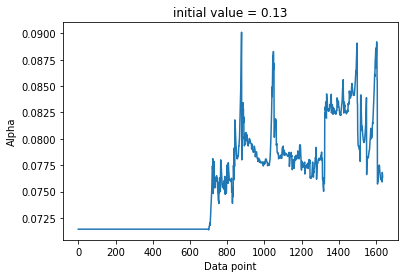

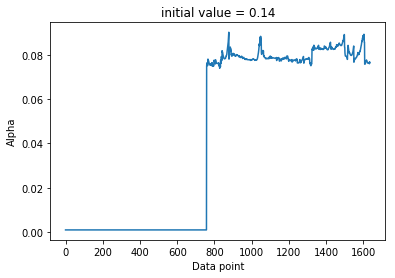

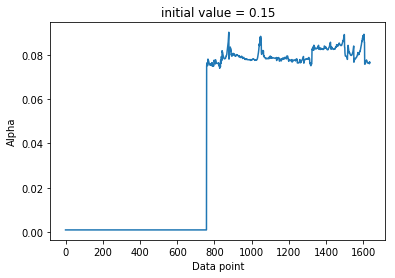

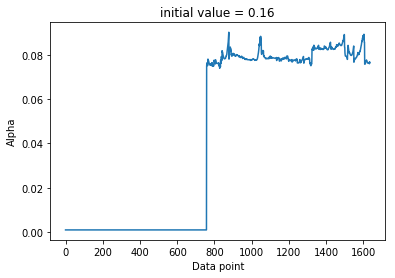

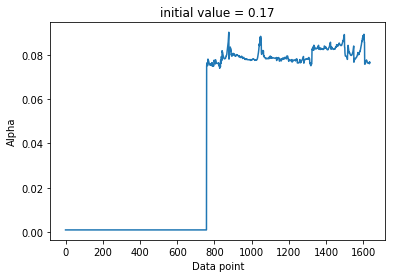

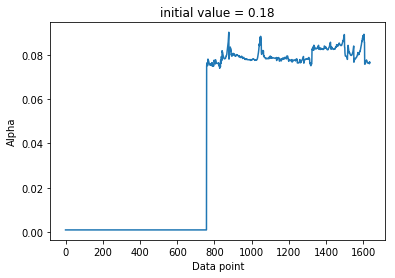

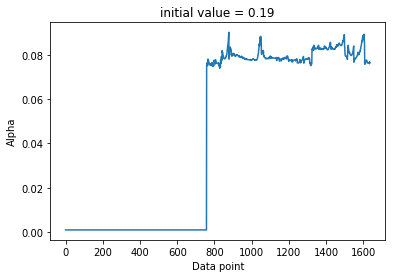

In [169]:
import matplotlib.pyplot as plt
for k in range(1, 20):
    plt.plot(expand_alpha(df, 5, 700, 0.01*k))
    a = 0.01*k
    plt.title('initial value = '+str(a))
    plt.ylabel('Alpha')
    plt.xlabel('Data point')
    plt.show()
    plt.close()
    
 

As an example, set expanding window=800
Change of variance with different step ahead

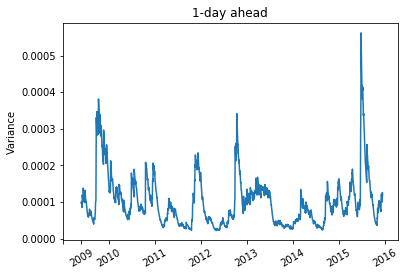

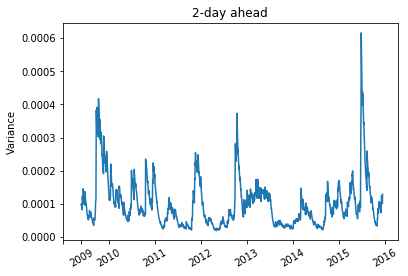

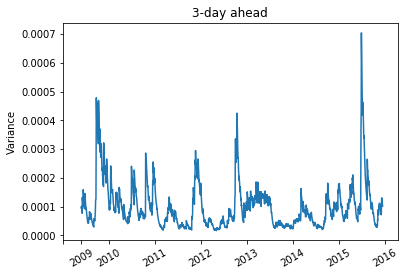

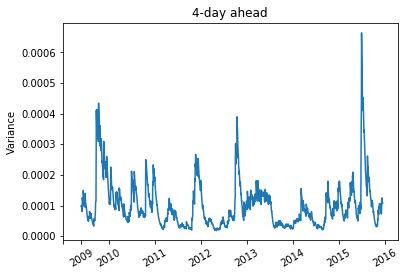

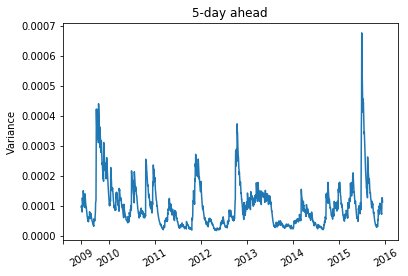

In [12]:
import matplotlib.pyplot as plt
for k in range(1, 6):
    plt.plot(expand_v(df, k, 800, 0.07))
    plt.title(str(k)+'-day ahead')
    plt.ylabel('Variance')
    ax = plt.gca()
    ax.set_xticks([-100, 0, 150, 400, 650, 900, 1150, 1400, 1650])
    ax.set_xticklabels(['','2009','2010','2011', '2012', '2013', '2014', '2015','2016'], rotation=30)
    plt.show()
    plt.close()

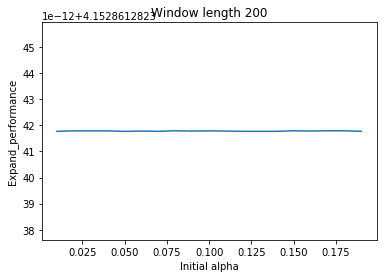

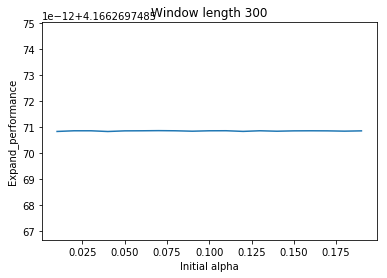

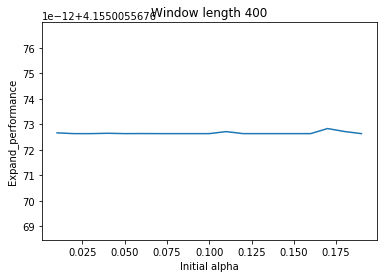

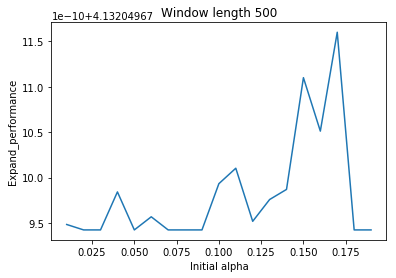

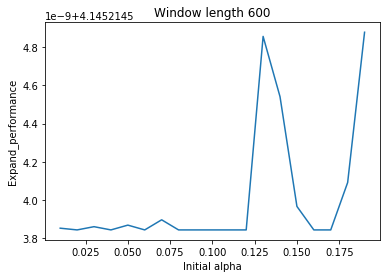

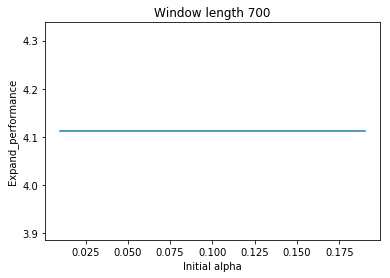

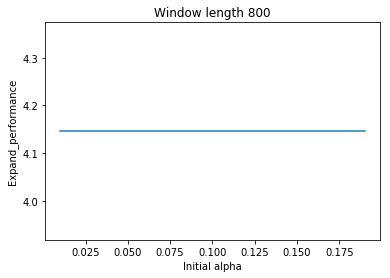

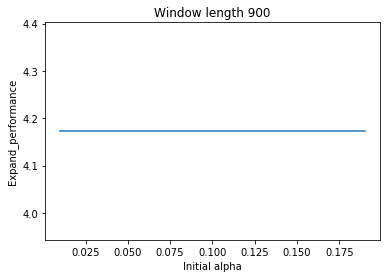

In [177]:
# As an example, set step ahead=5
# change of expand performance with different initial alpha, given various
# expanding window length

array = np.arange(0.01,0.2,0.01,dtype=float)
for k in range(200, 1000, 100):
    a = [];
    for i in range(0, len(array)):
        a.append(expand_performance(df, 5, k, array[i]));

    plt.plot(array, a);
    plt.xlabel('Initial alpha')
    plt.ylabel('Expand_performance')
    plt.title('Window length ' + str(k))
    plt.show()
    plt.close()

# From the picture, expand performance is relatively stable with different
# initial alpha, under various expanding window length.

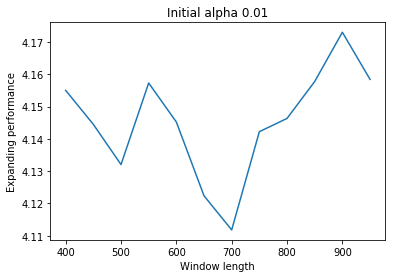

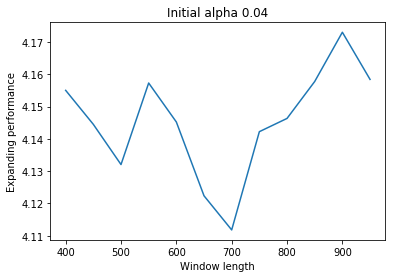

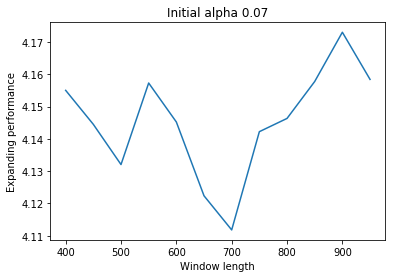

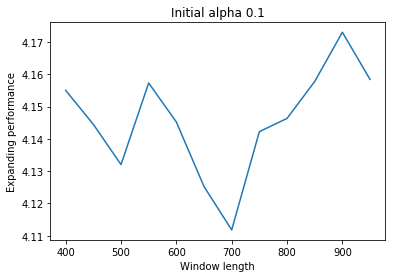

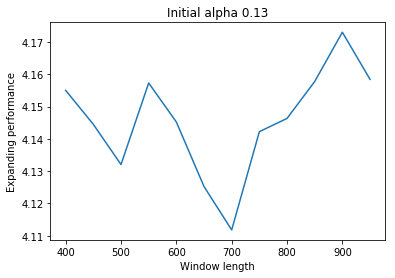

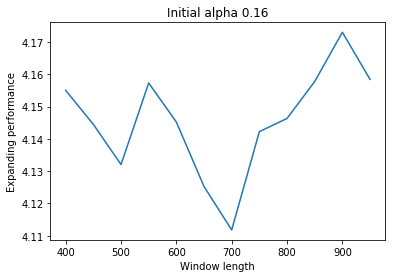

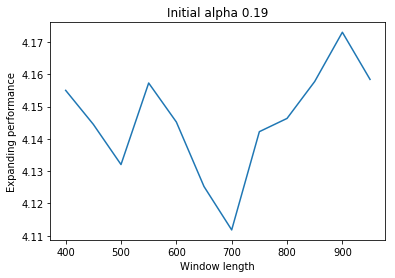

In [181]:
# expand performance with different initial alpha and different initial 
# expanding window length. step ahead=5

for k in range(0, 7):
    array = np.arange(400,1000,50,dtype=int)
    a = [];
    for i in range(0, len(array)):
        a.append(expand_performance(df, 5, array[i], 0.01*(3*k + 1)));

    plt.plot(array, a);
    plt.xlabel('Window length')
    plt.ylabel('Expanding performance')
    plt.title('Initial alpha ' + str(0.01*(3*k+1)))
    plt.show()
    plt.close()




In [18]:
# Evalutation of model by rolling window

def rolling_alpha(returns, step_ahead, window_length, x0):
    l = window_length
    initial = returns[:l+step_ahead]
    alpha = optimal_parameter(initial, step_ahead, x0)
    rolling_alpha = []
    for j in range(0, l):
        rolling_alpha.append(alpha)
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[i: i+l+step_ahead]
        alpha = optimal_parameter(window, step_ahead, alpha)
        rolling_alpha.append(alpha)
    return rolling_alpha

In [19]:
def rolling_v(returns, step_ahead, rolling_window_length, x0):
    l = rolling_window_length
    initial = returns[:l+step_ahead]
    alpha = optimal_parameter(initial, step_ahead, x0)
    rolling_v = variance(initial[:l], alpha)
    tempo = rolling_v[-1]
    for i in range(1, len(returns)-step_ahead-l+1):
        rolling_window = returns[i: i+l+step_ahead]
        alpha = optimal_parameter(rolling_window, step_ahead, alpha)
        tempo = variance(rolling_window[:l], alpha)[-1]
        rolling_v = np.append(rolling_v, tempo)
    return rolling_v

In [20]:
# To compute log likelihood, we throw away initial window and 100 points after it

def rolling_performance(returns, step_ahead, window_length, x0):
    estimate_v = rolling_v(returns, step_ahead, window_length, x0)
    returns_shift = returns[:-step_ahead]
    b = (- np.log(estimate_v) - (returns_shift ** 2)/ estimate_v)
    return sum(b[window_length+100:]) / (2*(len(b)-window_length-100))

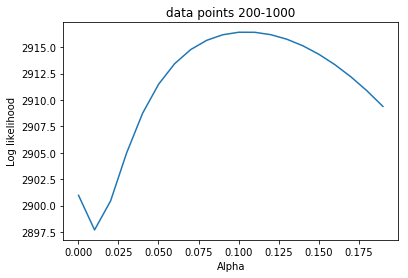

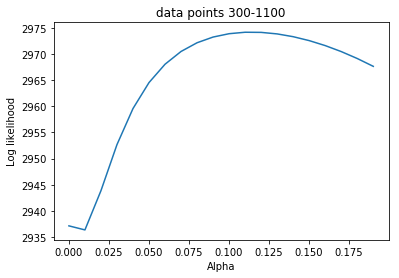

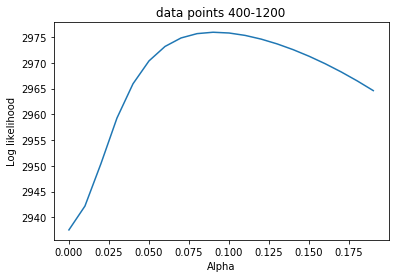

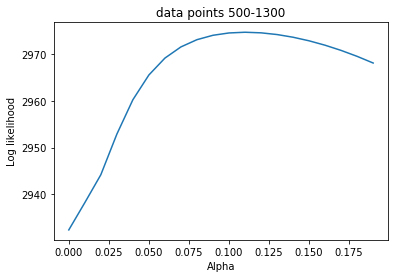

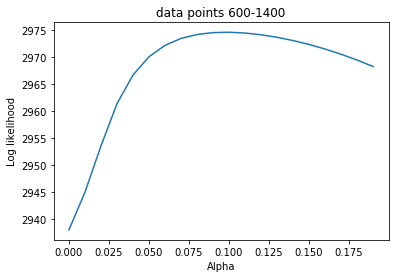

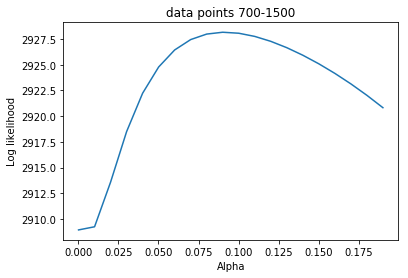

In [187]:
# Change of log likelihood by different alpha, given various segment of data

array = np.arange(0.0001,0.2,0.01)
for k in range(200, 800, 100):
    a = [];
    for i in range(0, len(array)):
        a.append(log_like(5, [array[i]], df[k:k+805]));

    plt.plot(array, a);
    plt.xlabel('Alpha')
    plt.ylabel('Log likelihood')
    plt.title('data points '+str(k)+ '-'+ str(k+800))
    plt.show()
    plt.close()

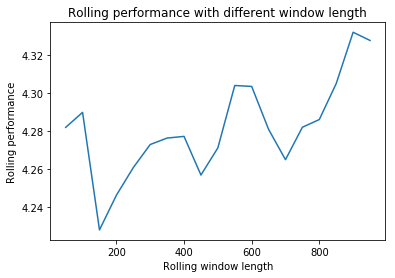

In [193]:
# Rolling performance with different rolling window length,
# initial alpha is set to 0.07, step ahead is set to 5.

array = np.arange(50,1000,50,dtype=int)
a = [];
for i in range(0, len(array)):
    a.append(rolling_performance(df, 5, array[i], 0.07));

plt.plot(array, a);
plt.xlabel('Rolling window length')
plt.ylabel('Rolling performance')
plt.title('Rolling performance with different window length')
plt.show()

# Remark: we want to make sure the model is stable with initial value. See blow.

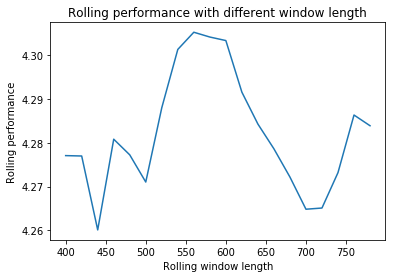

In [196]:
array = np.arange(400,800,20,dtype=int)
a = [];
for i in range(0, len(array)):
    a.append(rolling_performance(df, 5, array[i], 0.07));

plt.plot(array, a);
plt.xlabel('Rolling window length')
plt.ylabel('Rolling performance')
plt.title('Rolling performance with different window length')
plt.show()

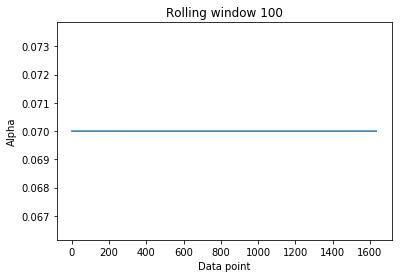

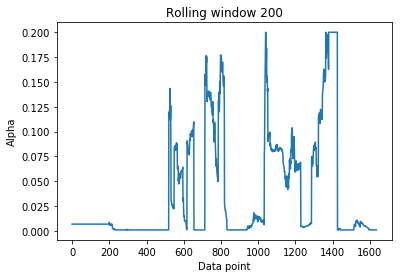

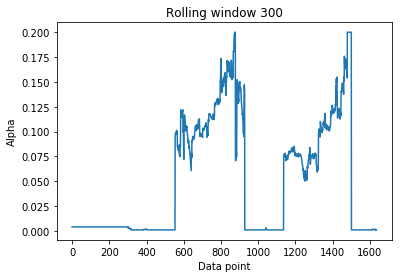

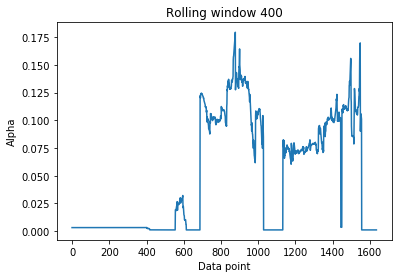

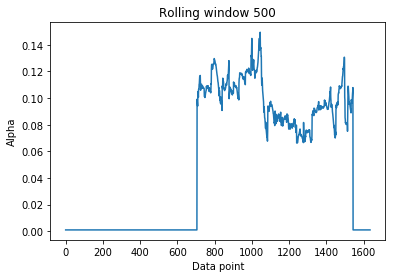

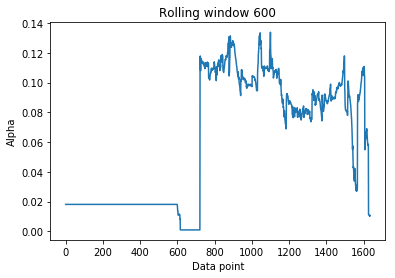

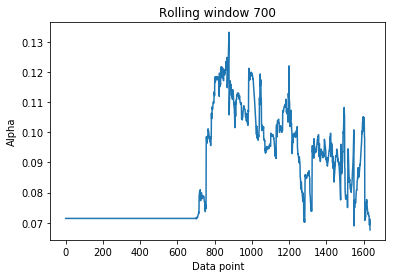

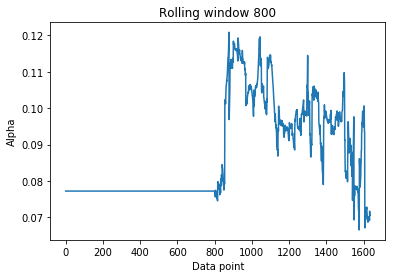

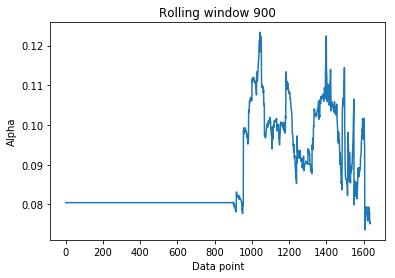

In [197]:
# Change of rolling alpha with different rolling window length, 
# initial value is set to 0.07, step ahead is set to 5.

import matplotlib.pyplot as plt
for k in range(1, 10):
    plt.plot(rolling_alpha(df, 5, 100*k, 0.07))
    plt.title('Rolling window '+ str(100*k))
    plt.xlabel('Data point')
    plt.ylabel('Alpha')
    plt.show()
    plt.close()

# From the picture, if we want alpha to be relatively stable, 
# we may assume the window length should be at least 500.


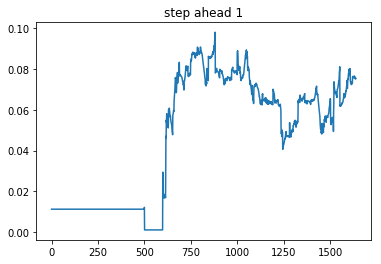

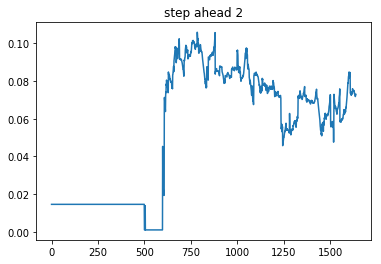

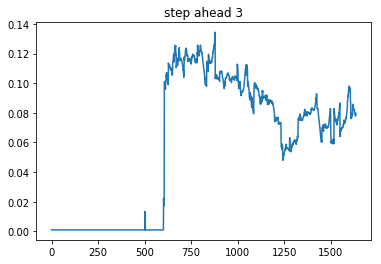

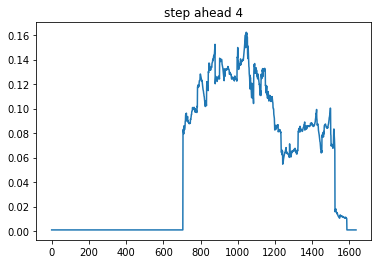

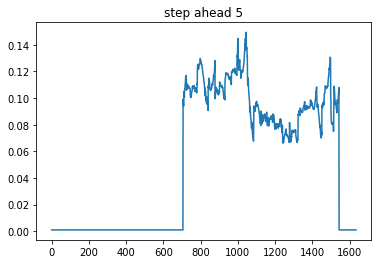

In [215]:
# rolling alpha with different step ahead

import matplotlib.pyplot as plt
for k in range(1, 6):
    plt.plot(rolling_alpha(df, k, 500, 0.07))
    plt.title('step ahead '+str(k))
    plt.show()
    plt.close()
    
# Remark: as the step ahead becomes larger, alpha becomes more unstable.
# For example, if step ahead=1, we may just need the rolling window length>500
# or even smaller.

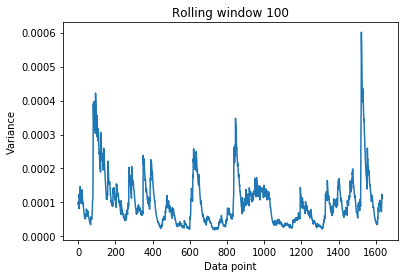

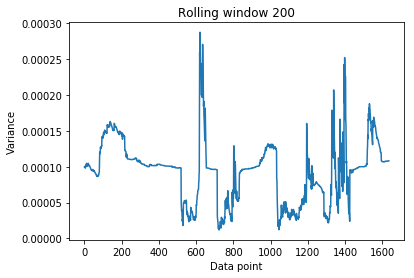

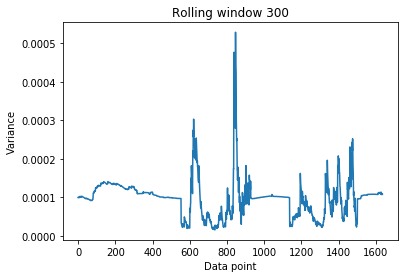

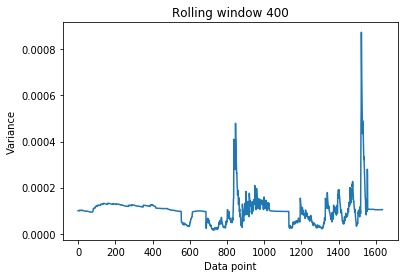

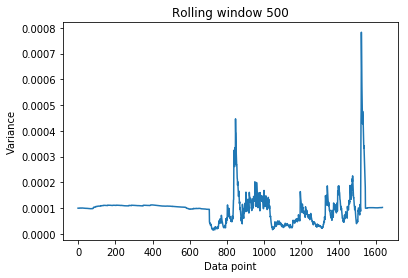

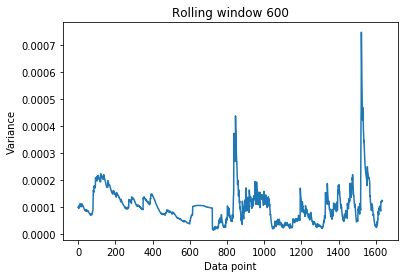

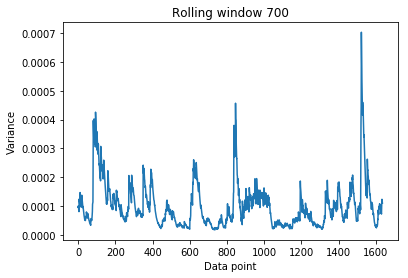

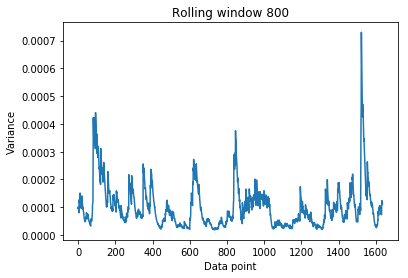

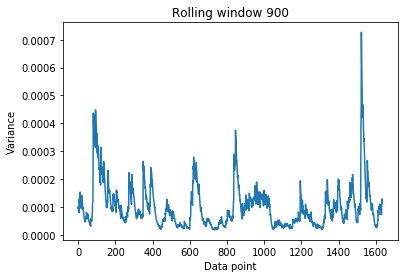

In [214]:
# change of variance with different window length

import matplotlib.pyplot as plt
for k in range(1, 10):
    plt.plot(rolling_v(df, 5, 100*k, 0.07))
    plt.title('Rolling window '+ str(100*k))
    plt.xlabel('Data point')
    plt.ylabel('Variance')
    plt.show()
    plt.close()

# Remark: if we want the variance to be relatively stable, we choose window
# length to be at least 700.

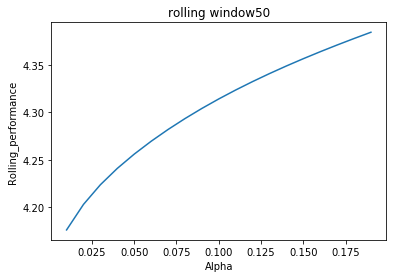

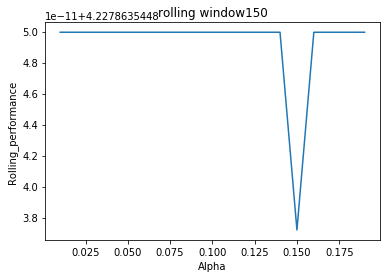

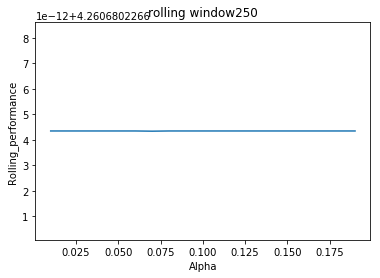

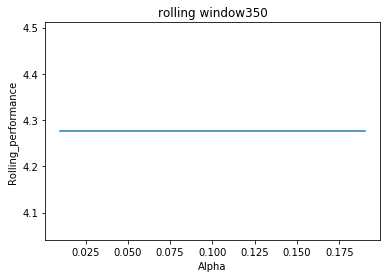

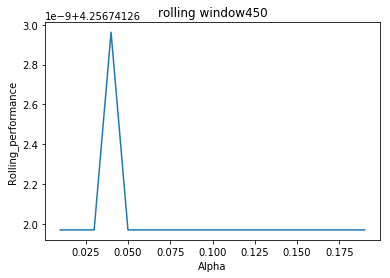

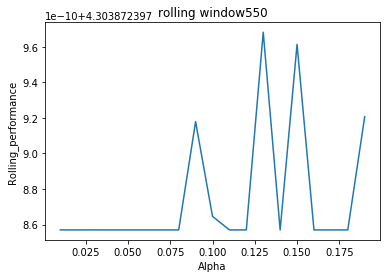

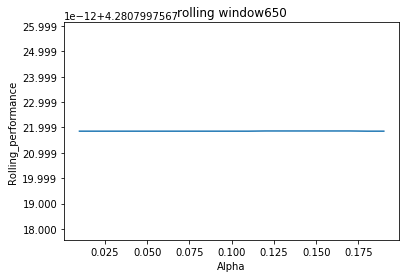

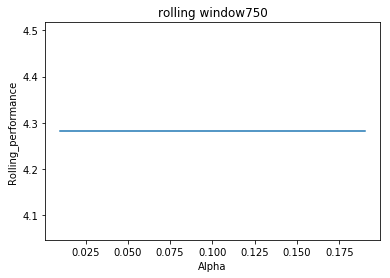

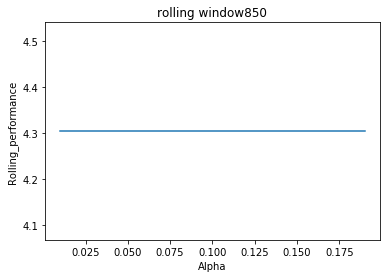

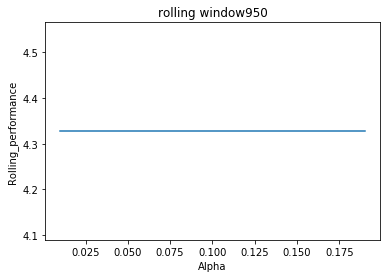

In [198]:
# rolling performance with different initial value and different window length
# step ahead=5

array = np.arange(0.01,0.2,0.01,dtype=float)
for k in range(50, 1000, 100):
    a = [];
    for i in range(0, len(array)):
        a.append(rolling_performance(df, 5, k, array[i]));

    plt.plot(array, a);
    plt.xlabel('Alpha')
    plt.ylabel('Rolling_performance')
    plt.title('rolling window' + str(k))
    plt.show()
    plt.close()
    
# rolling performance is relatively stable with different window length
# and different initial value.

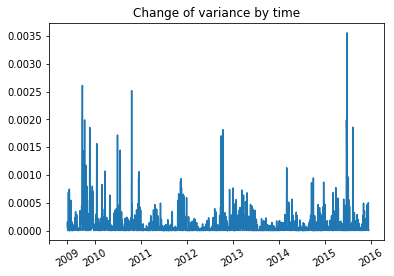

In [170]:
import matplotlib.pyplot as plt

plt.plot(df)
ax = plt.gca()
ax.set_xticks([-100, 0, 150, 400, 650, 900, 1150, 1400, 1650])
ax.set_xticklabels(['','2009','2010','2011', '2012', '2013', '2014', '2015','2016'], rotation=30)
plt.title('Change of returns by time')
plt.show()

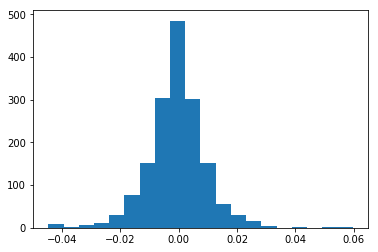

In [199]:
# histogram for returns
plt.hist(df, bins=20)
plt.show()


In [13]:
import math
def expand_hist(returns, step_ahead, window_length, x0):
    estimate_v = expand_v(returns, step_ahead, window_length, x0)[window_length+100:]
    returns_shift =  returns[window_length+100+step_ahead:] 
    return returns_shift / np.sqrt(estimate_v)




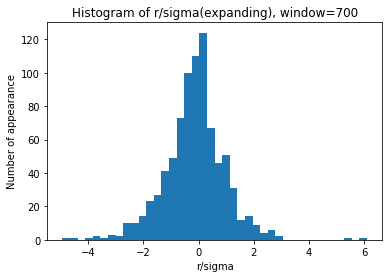

In [14]:
plt.hist(expand_hist(df, 5, 700, 0.07), bins=40)
plt.xlabel('r/sigma')
plt.ylabel('Number of appearance')
plt.title('Histogram of r/sigma(expanding), window=700')
plt.show()

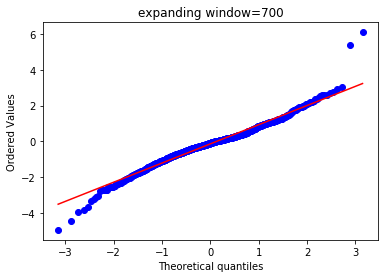

In [15]:
import pylab 
import scipy.stats as stats


stats.probplot(expand_hist(df, 5, 700, 0.07), dist="norm", plot=pylab)
pylab.title('expanding window=700')
pylab.show()

In [21]:
def rolling_hist(returns, step_ahead, window_length, x0):
    estimate_v = rolling_v(returns, step_ahead, window_length, x0)[window_length+100:]
    returns_shift =  returns[window_length+100+step_ahead:] 
    return returns_shift / np.sqrt(estimate_v)




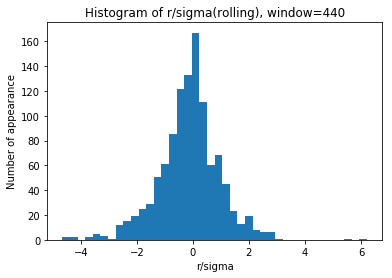

In [22]:
plt.hist(rolling_hist(df, 5, 440, 0.07), bins=40)
plt.xlabel('r/sigma')
plt.ylabel('Number of appearance')
plt.title('Histogram of r/sigma(rolling), window=440')
plt.show()

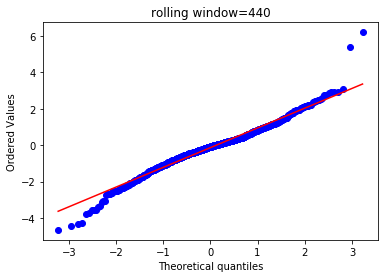

In [23]:
stats.probplot(rolling_hist(df, 5, 440, 0.07), dist="norm", plot=pylab)
pylab.title('rolling window=440')
pylab.show()

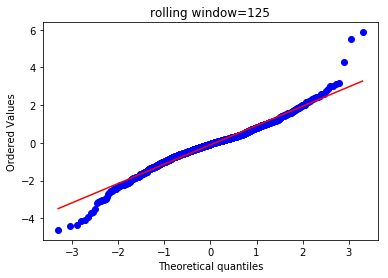

In [24]:
stats.probplot(rolling_hist(df, 5, 125, 0.07), dist="norm", plot=pylab)
pylab.title('rolling window=125')
pylab.show()

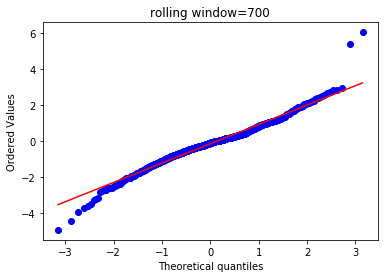

In [25]:
stats.probplot(rolling_hist(df, 5, 700, 0.07), dist="norm", plot=pylab)
pylab.title('rolling window=700')
pylab.show()